In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


data_folder = '../data/emg_pilot/'
filename_small_movements = "record-[2023.12.04-14.29.07].gdf"


left_hand_event = "769"
right_hand_event = "770"
end_of_trial_event = "800"

event_ids = dict(left=1, right=2, rest=3)


ModuleNotFoundError: No module named 'sklearn'

In [25]:
raw = mne.io.read_raw_gdf(data_folder + filename_small_movements,
                             preload=True)
raw = raw.drop_channels("Channel 1").pick(["EX 1", "EX 2", "EX 3", "EX 4"])
raw = raw.set_eeg_reference()
raw = raw.set_channel_types(dict.fromkeys(raw.ch_names, "emg"))

raw = raw.notch_filter(np.arange(50, 501, 50), picks='emg', method='fir', phase='minimum') # Multiple notches only implemented for FIR

raw = raw.filter(30, 500, picks='emg', method='iir', phase='forward')
events, _ = mne.events_from_annotations(raw, event_id={left_hand_event: 1, right_hand_event: 2, end_of_trial_event: 3})
raw

Extracting EDF parameters from /Users/ivopascal/Documents/PhD/CarDrivingBCI/data/emg_pilot/record-[2023.12.04-14.29.07].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)

No data channels found. The highpass and lowpass values in 

<RawGDF | record-[2023.12.04-14.29.07].gdf, 4 x 882816 (431.1 s), ~27.0 MB, data loaded>

In [28]:
cue_time = 1.25
move_time = 3.75

epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    cue_time,
    cue_time + move_time,
    baseline=None,
    preload=True,
)

Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 7681 original time points ...
0 bad epochs dropped


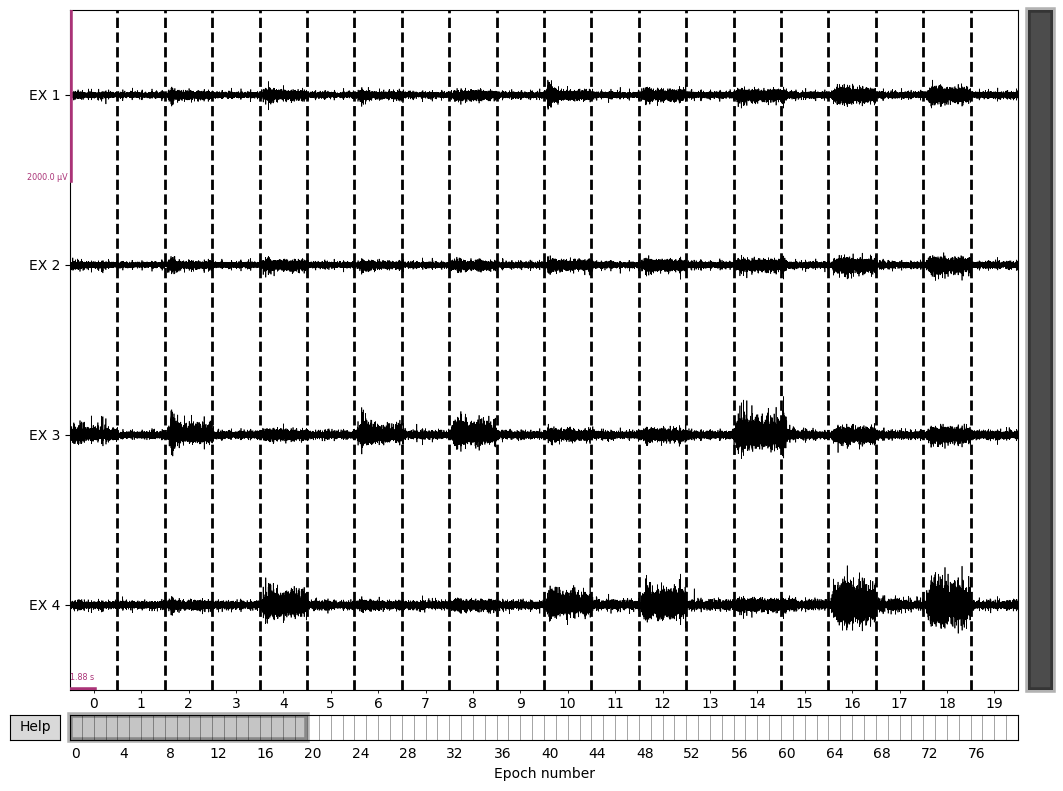

In [29]:
epochs.plot(picks='emg', events=events) 
plt.show() # This actually looks quite good. If we focus on EX3 and EX4 we can clearly distinguish left, right and rest

In [30]:
hilbert_epochs = epochs_band.apply_hilbert(envelope=True, picks='emg')
X = hilbert_epochs.get_data()
y = hilbert_epochs.events[:, -1] - 1
X = X.mean(axis=2)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.75)

In [36]:
model = LDA()
for i in range(4):
    model.fit(X_train[:, i].reshape(-1, 1), y_train)
    print(f"Performance using only EX {i + 1}")
    print(classification_report(y_test, model.predict(X_test[:, i].reshape(-1, 1)), target_names=['Left', 'Right', 'Rest']))



Performance using only EX 1
              precision    recall  f1-score   support

        Left       1.00      0.67      0.80        15
       Right       0.69      0.85      0.76        13
        Rest       0.94      1.00      0.97        32

    accuracy                           0.88        60
   macro avg       0.88      0.84      0.84        60
weighted avg       0.90      0.88      0.88        60

Performance using only EX 2
              precision    recall  f1-score   support

        Left       0.92      0.73      0.81        15
       Right       0.71      0.77      0.74        13
        Rest       0.94      1.00      0.97        32

    accuracy                           0.88        60
   macro avg       0.86      0.83      0.84        60
weighted avg       0.89      0.88      0.88        60

Performance using only EX 3
              precision    recall  f1-score   support

        Left       0.87      0.87      0.87        15
       Right       1.00      0.85      0.92  

In [39]:
model.fit(X_train, y_train)
print(f"Performance using all channels")

print(classification_report(y_test, model.predict(X_test), target_names=['Left', 'Right', 'Rest']))


Performance using all channels
              precision    recall  f1-score   support

        Left       1.00      1.00      1.00        15
       Right       1.00      1.00      1.00        13
        Rest       1.00      1.00      1.00        32

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [40]:
model.score(X_test, y_test)

1.0

In [93]:
from sklearn.model_selection import cross_val_score

def accuracy_for_time(t):
    
    cue_time = 1.25
    move_time = 3.75

    if t > move_time:
        return
    lost_time = move_time - t

    cue_time = cue_time + lost_time / 2 # + because we want to move forward in time
    move_time = move_time - lost_time 

    epochs = mne.Epochs(
        raw,
        events,
        event_ids,
        cue_time,
        cue_time + move_time,
        baseline=None,
        preload=True,
    )

    hilbert_epochs = epochs.apply_hilbert(envelope=True, picks='emg')
    X = hilbert_epochs.get_data()
    y = hilbert_epochs.events[:, -1] - 1
    
    X = X.mean(axis=2)

    return cross_val_score(model, X, y, cv=10).mean()
mne.set_log_level("WARNING")

ts = np.arange(0, 3.75, 0.05)
acc = [accuracy_for_time(t) for t in ts]

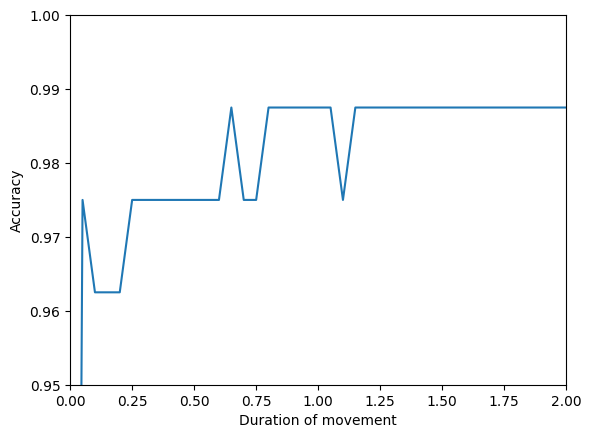

In [96]:
plt.plot(ts, acc)
plt.xlabel("Duration of movement")
plt.ylabel("Accuracy")
plt.xlim(0.0, 2)
plt.ylim(0.95, 1.0)
plt.show()

In [72]:
accuracy_for_time(2)

array([0.9375, 1.    , 1.    , 1.    , 1.    ])

In [92]:
acc

[0.7125,
 0.9875,
 0.9625,
 0.9625,
 0.9625,
 0.975,
 0.975,
 0.9625,
 0.9625,
 0.975,
 0.9625,
 0.9625,
 0.9625,
 0.975,
 0.9625,
 0.9625,
 0.9625,
 0.9625,
 0.9625,
 0.9625,
 0.9625,
 0.975,
 0.9625,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875]